## Data Harmonisation for EEG Foundational Model Using Correlation based Channel Reordering

**Submitted by:**  
Renuka Sahoo  
6427748  
MSc Neuroscience  
University of Bremen  
Module - 02-BIO-MA-MN-LAB1: Lab Project 1

#### Abstract

EEG analysis and machine learning models often assume that EEG channels follow a fixed and known order. In practice, however, EEG datasets may contain inconsistent or undocumented channel ordering, especially when data are collected across many sessions or devices. Such mismatches can disturb the spatial relationships between channels and reduce the reliability of further analysis. This study explores whether correlations between EEG channels can be used to automatically recover a consistent channel order when the true order is unknown.

EEG recordings from 183 sessions were analyzed, including a large dataset with unknown channel ordering and a smaller dataset with known and intentionally shuffled channel configurations. All data were recorded using an 8-channel Unicorn EEG system and processed using the same preprocessing steps. For each session, Pearson correlation matrices were computed between channels. Channel reordering was then performed by searching for the permutation that maximized similarity with a reference correlation matrix obtained from correctly ordered data.

The correlation-based reordering improved similarity to the reference compared to unordered or shuffled data. However, applying the known physical channel order did not always result in the highest correlation values. Further analysis showed that noisy or faulty channels can strongly affect correlation patterns and reduce similarity even when the correct channel order is used. This suggests that correlation-based reordering reflects functional relationships between channels rather than exact physical electrode positions. Overall, the results indicate that it should be used as a complementary tool rather than a fully unsupervised solution.

#### Introduction

EEG is a non-invasive neuroimaging technique with high temporal resolution but low spatial specificity due to volume conduction and noise, making preprocessing and signal harmonization critical for reliable multi-session and cross-subject analysis (Truong et al., 2022). 

Often EEG is preferred for longitudinal or multi-session experiments because it offers a portable, non-invasive, low cost solution and a relatively accessible window into brain activity (Orban et al., 2022; Meyer et al., 2013). While dealing with multi- session experiments, longitudinal studies, a very important requirement for the results to be reliable is stable and reproducible measurements. The major challenge in these cases is the robust performance across multi-session and cross-subject experiments(Meyer et al., 2013; Saha & Baumert, 2020). Neural signals are inherently non-stationary; the statistical properties of the signal change over time (intra-subject variability) and differ significantly between individuals (inter-subject variability). The signals have low signal to noise ratio since they inherently have artifacts due to eye blinks, muscle movements and electrical interferance(Cui et al., 2024; Islam et al., 2016; Roy et al., 2019). Even though EEG has a high temporal resolution but it provides low spatial resolution. All of these pose a hindernace in the localisation of the brain activity or decoding the cognitive state(Cui et al., 2024). To address the limitations of subject-specific training, the field is moving toward Foundational Models which are large-scale, pre-trained neural networks designed to learn generalizable representations from massive datasets. Similar to how Large Language Models (LLMs) understand text syntax, EEG foundational models aim to learn the underlying grammar of the brain dynamics. Training on large datasets would help in further downstream tasks such as seizure detection, sleep staging, or emotion classification. The ultimate goal is a "universal" EEG encoder that is robust to noise and capable of handling data from heterogeneous sources(Wang et al., 2025). Moreover, the efficicacy of these foundational models is also highly sensitive to the preprocessing pipeline. Slight variations in preprocessing such as differing sampling rates, referencing schemes, or filtering bandwidths can cause significant domain shifts, leading to model failure(Mattiev et al., 2023).

Among these preprocessing factors, the Channel Ordering is a critical, yet often overlooked, barrier to developing universal foundational models. Standard 2D CNNs, which have achieved state-of-the-art results in computer vision, rely on "spatial locality" which assumes that pixel (i, j) is spatially related to pixel (i, j+1). In EEG, this assumption breaks down because:1. Different headsets use different channel counts (8 vs. 64) and layouts.2. The order of channels in the raw data matrix is often arbitrary. Channel 1 might be F_z in Dataset A but O_1 in Dataset B(Balsam et al., 2020). If a model learns that the top-left corner of the input represents the frontal lobe, and if its fed with a permuted matrix where the top-left is the occipital lobe, this  destroys the model's spatial feature extraction capabilities. Recent approaches like CHARM (Channel Reordering Module) attempt to learn a permutation matrix during training, while others like MMM use Transformer-based attention to be topology-agnostic.However, attention mechanisms are computationally expensive and learned permutation adds complexity(Yi et al., 2023). To enable efficient foundational models without complex attention mechanisms, the input channels must be reordered into a topologically consistent grid. This project explores the use of Correlation Matrices to perform this reordering.

Electrical potentials generated by a neural source spread through the conductive medium of the brain and skull, decaying with distance. Consequently, electrodes that are physically proximal on the scalp record highly correlated signals(Satyanarayana, 2014). Using correlation matrices to reorder channels offers a distinct advantage over fixed montage mapping or learned permutations - It does not require metadata about electrode positions (which is often missing). The data itself dictates the structure. Secondly, if the channels are shuffled, their correlation values remain unchanged. Sorting the input based on the correlation structure will consistently place highly correlated (neighboring) channels adjacent to each other in the matrix. Thirdly, by converting the arbitrary channel list into a structured "correlation image" or reordered time-series grid, we restore the spatial locality required by models thus ensuring robustness due to consistent channel ordering. Therefore, exploring correlation-based sorting offers a principled approach to reducing variability across heterogeneous EEG inputs and improving the robustness and efficiency of downstream processing in foundation models.


#### Methods

The project investigated whether inter-channel correlation structure could be used to infer the correct ordering of channels in multichannel EEG recordings. The available data consisted of two types of datasets: an initial large dataset (168 sessions) with unknown channel-order, and a newly collected dataset(15 sessions) for which channel orders(correct and incorrect) of the sessions were known which was specifically collected for this study. All these datasets were recorded with 8-channel Unicorn EEG system (Unicorn Hybrid Black). Because of the exploratory nature of the work, the methodological approach evolved iteratively and focused on developing a preprocessing pipeline, generating correlation matrices, and comparing ordering strategies under conditions with and without ground truth. 

In [1]:
#Imports
import os
import glob
import pyxdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from scipy.signal import iirnotch, filtfilt, butter
from scipy.stats import zscore
import math
import io
import contextlib
from pathlib import Path

All recordings were stored as xdf files. Separate directories were defined for the large dataset with unknown channel order (addressed as unknown order xdf files here) and dataset with known channel order. 

In [2]:
# Input datasets path (unknown order and the known order dataset)
unknown_order_dir = r"D:\A. NEUROSCIENCE\CSL LAB Project I\Data"
known_order_dir = r"D:\A. NEUROSCIENCE\CSL LAB Project I\New collected data"

# Find all XDF files
unknown_order_xdf_files = glob.glob(os.path.join(unknown_order_dir, '**', '*.xdf'), recursive=True)
known_order_xdf_files = glob.glob(os.path.join(known_order_dir, '**', '*.xdf'), recursive=True)
print(f"Number of sessions in the unknown order dataset: {len(unknown_order_xdf_files)}")
print(f"Number of sessions in the known order dataset: {len(known_order_xdf_files)}")

Number of sessions in the unknown order dataset: 168
Number of sessions in the known order dataset: 15


First a complete inventory of all streams contained in the XDF files was created. Subsequently, EEG streams was filtered out using the stream name and ensuring that the number of samples was greater than zero. The streams were screened based on duration(greater than 60 sec at 250 Hz sampling rate) to ensure sufficient recording length for further analysis.

In [22]:
# Combine both datasets with labels
datasets = {
    "unknown_order": unknown_order_xdf_files,
    "known_order": known_order_xdf_files
}

# Filter out tiny files
datasets = {name: [f for f in files if os.path.getsize(f) > 1024] for name, files in datasets.items()}

# Stream data extraction
stream_records = []

for dataset_name, files in datasets.items():
    for file in files:
        try:
            streams, _ = pyxdf.load_xdf(file)

            for i, s in enumerate(streams):
                stream_type = s['info'].get('type', [''])[0]
                stream_name = s['info'].get('name', [''])[0]
                num_samples = len(s.get('time_stamps', []))

                stream_records.append({
                    "Dataset": dataset_name,
                    "File": file,
                    "Stream_Index": i,
                    "Stream_Type": stream_type,
                    "Stream_Name": stream_name,
                    "Num_Samples": num_samples
                })

        except Exception as e:
            stream_records.append({
                "Dataset": dataset_name,
                "File": file,
                "Stream_Index": None,
                "Stream_Type": "ERROR",
                "Stream_Name": str(e),
                "Num_Samples": None
            })

# Convert to DataFrame
df_streams = pd.DataFrame(stream_records)

# Save summary
df_streams.to_csv("stream_info_summary.csv", index=False)


Stream 1: Calculated effective sampling rate 0.0000 Hz is different from specified rate 250.0000 Hz.
Stream 1: Calculated effective sampling rate 76.9239 Hz is different from specified rate 4800.0000 Hz.
Stream 3: Calculated effective sampling rate 76.9236 Hz is different from specified rate 4800.0000 Hz.
Stream 2: Calculated effective sampling rate 76.9235 Hz is different from specified rate 4800.0000 Hz.
Stream 4: Calculated effective sampling rate 76.9237 Hz is different from specified rate 4800.0000 Hz.
Stream 1: Calculated effective sampling rate 76.9235 Hz is different from specified rate 4800.0000 Hz.
Stream 4: Calculated effective sampling rate 76.9235 Hz is different from specified rate 4800.0000 Hz.
Stream 1: Calculated effective sampling rate 76.9235 Hz is different from specified rate 4800.0000 Hz.
Stream 4: Calculated effective sampling rate 76.9238 Hz is different from specified rate 4800.0000 Hz.
Stream 1: Calculated effective sampling rate 76.9236 Hz is different from s

In [4]:
# EEG stream selection

df = pd.read_csv("stream_info_summary.csv")

# EEG stream identification using name/type
eeg_df = df[
    (
        df["Stream_Name"].str.contains("EEG|Unicorn", case=False, na=False) |
        df["Stream_Type"].str.contains("EEG", case=False, na=False)
    ) &
    (df["Num_Samples"] > 0)
].copy()

# Automatically inferred EEG stream names
eeg_stream_names = eeg_df["Stream_Name"].unique().tolist()

print("Detected EEG stream names:")
print(eeg_stream_names)


Detected EEG stream names:
['Unicorn', 'UnicornStream', 'UnicornEEG', 'unicorn', 'Unicorn_CSL_Laptop', 'Unicorn_CSL_LabPC', 'Unicorn_HCILab1', 'Unicorn_HCILab2', 'EEG']


In [5]:
#Calculation of total Duration of EEG streams
fs = 250  #Hz Sampling rate
MIN_DURATION = 60
total_seconds = 0

eeg_summary = []

for _, row in eeg_df.iterrows():
    duration = row["Num_Samples"] / fs

    status = "Valid EEG" if duration >= MIN_DURATION else "Too short"

    if duration >= MIN_DURATION:
        total_seconds += duration

    eeg_summary.append({
        "Dataset": row["Dataset"],
        "File": row["File"],
        "Stream_Name": row["Stream_Name"],
        "Num_Samples": row["Num_Samples"],
        "Duration_sec": duration,
        "Status": status
    })

df_eeg_summary = pd.DataFrame(eeg_summary)
df_eeg_summary.to_csv("xdf_files_summary_new.csv", index=False)


All datasets underwent the same preprocessing steps to ensure consistency. First, powerline interference was removed using a 50 Hz notch filter(quality factor of 30). To eliminate slow baseline drifts, a fourth-order high-pass filter with a cutoff frequency of 0.5 Hz was applied. The filtered signals were then mean-centered to remove channel-specific offsets. The cleaned continuous data were segmented into non-overlapping fixed-length windows of 60sec to reduce non-stationarity. Artifact detection was performed on a per-segment basis using a standard-deviation thresholding method: segments with excessively high variance were considered contaminated by artifacts. For every channel, samples were clipped to ±3 standard deviations around the block mean. This step prevented the extreme values from distorting correlation estimates.


In [6]:
# EEG Preprocessing and correlation functio
def process_eeg_stream(eeg_streams, fs, messages, block_duration = 60, files = None):
    """
    Preprocess EEG data and compute averaged correlation matrix.

    Steps:
        1. 50 Hz notch filtering
        2. High-pass filtering (0.5 Hz)
        3. Mean centering
        4. Block-wise correlation computation

    Parameters:
        eeg_stream : dict
            EEG stream loaded from XDF
        fs : int
            Sampling frequency (Hz)
        messages : list
            Logging container
        block_duration : int
            Block size in seconds

    Returns:
        correlation_matrix : pd.DataFrame or None
        nan_counts : pd.Series
    """
    
    eeg_data = eeg_streams['time_series']

    # Notch filter
    # Parameters
    freq = 50.0                           # Frequency to remove (50 Hz power line)
    quality_factor = 30.0                 # Quality factor for notch filter

    # Design notch filter
    b_notch, a_notch = iirnotch(freq, quality_factor, fs)

    # Apply notch filter to baseline_corrected data (channels along columns)
    filtered_data = filtfilt(b_notch, a_notch, eeg_data, axis=0)

    # high pass filter
    # Parameters
    cutoff = 0.5  # High-pass cutoff frequency in Hz
    order = 4

    # Butterworth high-pass filter
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)

    # Apply zero-phase filtering
    filtered_data_highpass = filtfilt(b, a, filtered_data, axis=0)

    columns = [f"Ch{i}" for i in range(filtered_data_highpass.shape[1])]

    filtered_highpass_df = pd.DataFrame(filtered_data_highpass, columns = columns)
    filtered_highpass_df = filtered_highpass_df.iloc[:, :8]

    # Diagnostic check: After filtering
    if filtered_highpass_df.isna().any().any():
        print("NaNs detected right after filtering!")
        print("NaN counts per channel:")
        print(filtered_highpass_df.isna().sum())
    else:
        print("No NaNs after filtering.")

    Nan_counts = filtered_highpass_df.isnull().sum()
    print(f"Nan_counts: {Nan_counts}")

    #mean centering
    filtered_highpass_df_mean_centering = filtered_highpass_df - filtered_highpass_df.mean()

    # Block-wise correlation computation

    block_size = int(block_duration * fs)
    n_samples = filtered_highpass_df_mean_centering.shape[0]
    n_channels = filtered_highpass_df_mean_centering.shape[1]
    num_blocks = n_samples // block_size

    if num_blocks == 0:
        messages.append(f"Data shorter than one block ({n_samples} samples). Skipping correlation.")
        return None, Nan_counts

    corr_matrices = []

    for i in range(num_blocks):
        start = i * block_size
        end = (i + 1) * block_size
        block = filtered_highpass_df_mean_centering.iloc[start:end, :].copy()

        # Diagnostic check: Block NaNs
        if block.isna().any().any():
            print(f"NaNs detected in block {i + 1} BEFORE clipping!")
            print(block.isna().sum())

        block_mean = block.mean()
        block -= block_mean

        for ch in block.columns:
            std_dev = block[ch].std()
            block.loc[:, ch] = np.clip(block[ch], -3*std_dev, 3*std_dev)

        # Diagnostic check: After clipping
        if block.isna().any().any():
            print(f"NaNs detected in block {i + 1} after clipping!")
            print(block.isna().sum())

        if block.isna().any().any():
            print(f"Cannot compute correlation for block {i+1}, contains NaNs")
            continue 

        try:
            corr_block = block.corr()
            corr_matrices.append(corr_block)
        except Exception as e:
            messages.append(f"Correlation failed in block {i + 1}: {e}")

    if len(corr_matrices) == 0:
        messages.append("No valid correlation blocks computed.")
        return None, Nan_counts

    correlation_matrix_filtered = sum(corr_matrices) / len(corr_matrices)
    messages.append(f"Averaged correlation across {len(corr_matrices)} blocks.")

    # returns correlation_matrix_filtered, Nan_counts
    return correlation_matrix_filtered,Nan_counts


Following preprocessing, an 8x8 Pearson inter-channel correlation matrices were calculated for each session. Block-wise correlation matrices were averaged to obtain a single correlation matrix per EEG stream. These matrices were stored along with metadata including subject, experiment, file name, and EEG stream name. For the initial dataset, where the correctness of channel ordering was unknown, these matrices were examined to evaluate whether any consistent structural patterns emerged.

In [7]:
# Main Processing Loop for Inter-channel Correlation matrix
# (Loop over known & unknown datasets)
# (Load EEG, compute correlations, save CSVs & heatmaps)

all_results = []

# Input directories
known_order_dir   = r"D:\A. NEUROSCIENCE\CSL LAB Project I\New collected data"
unknown_order_dir = r"D:\A. NEUROSCIENCE\CSL LAB Project I\Data"

# Output directories
images_known_dir   = "images_known_order"
images_unknown_dir = "images_unknown_order"

os.makedirs(images_known_dir, exist_ok=True)
os.makedirs(images_unknown_dir, exist_ok=True)

# process directories
all_root_dirs = [
    (known_order_dir, images_known_dir),
    (unknown_order_dir, images_unknown_dir)
]

for root_input_dir, root_output_dir in all_root_dirs:

    for subject_dir in sorted(os.listdir(root_input_dir)):
        subject_path = Path(root_input_dir)/subject_dir
        if not subject_path.is_dir():
            continue

        for experiment_dir in sorted(subject_path.iterdir()):
            if not experiment_dir.is_dir():
                continue
            
            correlations = []
            filenames = []
            rows = []
            xdf_files = list(experiment_dir.rglob("*.xdf"))
            xdf_files_nc = []
            eeg_names = []

            for files in xdf_files:
                if os.path.getsize(files) > 1024:
                    xdf_files_nc.append(files)

            num_xdf_files = (f"{experiment_dir.name}: {len(xdf_files_nc)} XDF files found")

            for files in xdf_files_nc:

                stdout_buffer = io.StringIO()
                stderr_buffer = io.StringIO()
                messages = []
                messages.append(f"Checking file:{files}")
                output_msg = "Not_processed"
                
                with contextlib.redirect_stdout(stdout_buffer), contextlib.redirect_stderr(stderr_buffer):
                    try:
                        streams , header = pyxdf.load_xdf(files)
                
                        eeg_streams = []
                        stream_details = []

                        for i, stream in enumerate(streams):
                            source_name = stream['info']['name'][0]   
                            source_type = stream['info']['type'][0]   
                            stream_details.append(f"Stream {i}: Name = {source_name}, Type = {source_type}")
                    
                            if any(name.lower() in source_name.lower() for name in eeg_stream_names):
                                eeg_streams.append(stream)

                        stream_summary = ", ".join(stream_details)

                        num_eeg = len(eeg_streams) 

                        for s in eeg_streams:
                            eeg_name = s['info']['name'][0]
                            stream_len = len(s['time_series'])

                            if stream_len == 0:
                                output_msg = f"Skipping empty EEG stream: {eeg_name} (length={stream_len})"
                                messages.append(output_msg)
                                corr_matrix = None
                                Nan_counts = None
                            else:
                                corr_matrix, Nan_counts = process_eeg_stream(s, fs, messages, files={files})
                                all_results.append({
                                'experiment': experiment_dir.name,
                                'file': str(files),
                                'eeg_name': eeg_name,
                                'corr_matrix': corr_matrix
                                })
                                output_msg = f"Empty cells: {Nan_counts}"

                                correlations.append(corr_matrix)
                                filenames.append(files)
                                eeg_names.append(eeg_name)

                            # Log per stream
                            row = [
                            subject_dir,
                            experiment_dir,
                            num_xdf_files,
                            files,
                            stream_summary,
                            num_eeg,
                            eeg_name,
                            output_msg,
                            internal_errors if internal_errors else None,
                            "\n".join(str(m) for m in messages)
                            ]
                            rows.append(row)

                    except Exception as e:
                        messages.append(f"Error processing file {files}: {e}")
                        output_msg = f"Error: {e}"

                # Collect internal output
                internal_output = stdout_buffer.getvalue().strip()
                internal_errors = stderr_buffer.getvalue().strip()
            
            print(f"Rows collected for {experiment_dir.name}: {len(rows)}")

            data_analysis_folder = r"D:\A. NEUROSCIENCE\CSL LAB Project I\Data analysis\DataAnalysis"
            output_folder = os.path.join(data_analysis_folder, "data_analysis_info")
            os.makedirs(output_folder, exist_ok=True)
            exp_name = experiment_dir.name.replace(" ", "_").replace("(", "").replace(")", "") 
            output_csv = os.path.join(output_folder, f"{exp_name}_summary_mean-centering & std dev_corrected_doublechannel_extract_segmentation(no interpolation nans).csv")

            # Creating a single "images" folder to store all PNGs
            images_dir = os.path.join(output_folder, "images")
            os.makedirs(images_dir, exist_ok=True)

            # Saving each experiment’s combined correlation matrix
            combined_png_path = os.path.join(images_dir, f"{exp_name}_corr_matrices.png")

            for corr, fname, eeg_name in zip(correlations, filenames, eeg_names):
                if not (isinstance(corr, (np.ndarray, pd.DataFrame)) and np.ndim(corr) == 2):
                    print(f"Invalid correlation from file: {fname}, stream: {eeg_name}")
            
            # Plot all correlation matrices
            num_plots = len(correlations)
            cols = 3

            if num_plots == 0:
                print(f"No correlation matrices found for {experiment_dir.name}, skipping plot.")
                fig, ax = plt.subplots(figsize=(6,5))
                ax.text(0.5, 0.5, "No valid correlation matrices", ha='center', va='center', fontsize=12)
                ax.axis('off')  # hide axes
                plt.tight_layout()
                plt.close()
            else:
                plot_rows = math.ceil(num_plots / cols)

                fig, axes = plt.subplots(plot_rows, cols, figsize=(6*cols, 5*plot_rows))
                axes = axes.flatten()  

                valid_data = [(corr, fname, eeg_name) for corr, fname, eeg_name in zip(correlations, filenames, eeg_names)
                        if isinstance(corr, (np.ndarray, pd.DataFrame)) and np.ndim(corr) == 2 and corr.size > 0]
                
                if len(valid_data) < len(correlations):
                    print(f"Skipped {len(correlations) - len(valid_data)} invalid correlation matrices.")

                for i, (ax, (corr, fname, eeg_name)) in enumerate(zip(axes, valid_data)):
                    sns.heatmap(corr, cmap='coolwarm', vmin=0, vmax=1, annot=True, ax=ax)
                    ax.set_title(f"{os.path.basename(os.path.dirname(fname))}/"
                        f"{os.path.basename(fname)}\nStream: {eeg_name}",
                        fontsize=9)

                # Hide empty subplots
                for j in range(i+1, len(axes)):
                    fig.delaxes(axes[j])

                plt.tight_layout()
            
            plt.savefig(combined_png_path, dpi=300)
            plt.close()
            print(f"Saved combined correlation matrix PNG:\n{combined_png_path}")

            # Write to CSV with clear column headers
            with open(output_csv, "w", newline="", encoding="utf-8") as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow([
                    "Subject_Folder",
                    "Experiment_Folder",
                    "No of xdf files",
                    "File",
                    "Streams",
                    "num_eeg",
                    "EEG_stream_name",
                    "Output",
                    "Errors",
                    "Messages",
                ])
                writer.writerows(rows)

Rows collected for sub-correct: 4
Saved combined correlation matrix PNG:
D:\A. NEUROSCIENCE\CSL LAB Project I\Data analysis\DataAnalysis\data_analysis_info\images\sub-correct_corr_matrices.png
Rows collected for sub-incorrect: 10
Saved combined correlation matrix PNG:
D:\A. NEUROSCIENCE\CSL LAB Project I\Data analysis\DataAnalysis\data_analysis_info\images\sub-incorrect_corr_matrices.png
Rows collected for images: 0
No correlation matrices found for images, skipping plot.
Saved combined correlation matrix PNG:
D:\A. NEUROSCIENCE\CSL LAB Project I\Data analysis\DataAnalysis\data_analysis_info\images\images_corr_matrices.png
Rows collected for BPR_GRP_0(1): 27
Saved combined correlation matrix PNG:
D:\A. NEUROSCIENCE\CSL LAB Project I\Data analysis\DataAnalysis\data_analysis_info\images\BPR_GRP_01_corr_matrices.png
Rows collected for Casual EEG Recordings: 20
Saved combined correlation matrix PNG:
D:\A. NEUROSCIENCE\CSL LAB Project I\Data analysis\DataAnalysis\data_analysis_info\images\C

Pairwise correlations between all correlation matrices from the same experiment were calculated to assess similarity between EEG streams within an experiment. For each experiment, the upper‑triangular (excluding diagonal) elements of two matrices were vectorised and compared using Pearson correlation. The resulting values were assembled into an experiment‑specific similarity matrix and plotted as a heatmap with an accompanying index–file mapping. This analysis was performed for both the unknown‑order and known‑order datasets.

In [8]:
#within experiment similarity analysis
from itertools import combinations

pairwise_corrs = []

for exp_name in sorted(set(res['experiment'] for res in all_results)):
    exp_results = [res for res in all_results if res['experiment'] == exp_name]
    
    """Correlation between upper triangles of two matrices."""
    for res1, res2 in combinations(exp_results, 2):
        corr1, corr2 = res1['corr_matrix'], res2['corr_matrix']

        if isinstance(corr1, pd.DataFrame):
            corr1 = corr1.values
        if isinstance(corr2, pd.DataFrame):
            corr2 = corr2.values

        if corr1 is None or corr2 is None or corr1.size == 0 or corr2.size == 0:
            continue

        triu_idx = np.triu_indices_from(corr1, k=1)
        vals1 = corr1[triu_idx]
        vals2 = corr2[triu_idx]

        corr_between = np.corrcoef(vals1, vals2)[0, 1]

        pairwise_corrs.append({
            'experiment': exp_name,
            'file_1': res1['file'],
            'file_2': res2['file'],
            'corr_strength': corr_between
        })

within_exp_corr_df = pd.DataFrame(pairwise_corrs)

# Save heatmap and mapping

for exp_name, df_exp in within_exp_corr_df.groupby('experiment'):
    files = sorted(set(df_exp['file_1']).union(df_exp['file_2']))
    n_files = len(files)

    corr_matrix = np.full((n_files, n_files), np.nan)
    file_to_idx = {f: i for i, f in enumerate(files)}

    for _, row in df_exp.iterrows():
        i, j = file_to_idx[row['file_1']], file_to_idx[row['file_2']]
        corr_matrix[i, j] = row['corr_strength']
        corr_matrix[j, i] = row['corr_strength']

    np.fill_diagonal(corr_matrix, 1)

    # Create readable labels
    file_labels = [f"{Path(f).parent.name}/{Path(f).name}" for f in files]
    index_mapping = {i: label for i, label in enumerate(file_labels)}

    # FIGURE (heatmap + mapping)

    fig = plt.figure(figsize=(max(10, n_files * 1.1), max(8, n_files * 1.1)))
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 2])

    ax_heatmap = fig.add_subplot(gs[0])
    ax_text = fig.add_subplot(gs[1])
    ax_text.axis("off")

    sns.heatmap(
        corr_matrix,
        ax=ax_heatmap,
        xticklabels=list(index_mapping.keys()),
        yticklabels=list(index_mapping.keys()),
        cmap='coolwarm',
        vmin=0,
        vmax=1,
        annot=True,
        square = True,
        fmt=".2f",
        linewidths=0.4,
        linecolor='gray',
        cbar_kws={'label': 'Correlation Strength'}
    )

    ax_heatmap.set_title(f"Within-Experiment Correlation\n{exp_name}", fontsize=14)
    ax_heatmap.set_xticklabels(ax_heatmap.get_xticklabels(), rotation=45, ha='right')

    # mapping text
    mapping_text = "\n".join(f"{idx}: {label}" for idx, label in index_mapping.items())
    ax_text.text(
        0,
        1,
        f"Index → File mapping\n\n{mapping_text}",
        va='top',
        fontsize=11,
        wrap = True,
        family='monospace'
    )

    plt.tight_layout()

    OUTPUT_DIR = "Comparing matrix similarity in within-experiment sessions"
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    out_path = os.path.join(OUTPUT_DIR, f"{exp_name}_within_experiment_correlation_matrix.png")
    plt.savefig(out_path, dpi=300)
    plt.close(fig)

    print(f"Saved: {out_path}")


Saved: Comparing matrix similarity in within-experiment sessions\BPR_GRP_0(1)_within_experiment_correlation_matrix.png
Saved: Comparing matrix similarity in within-experiment sessions\Casual EEG Recordings_within_experiment_correlation_matrix.png
Saved: Comparing matrix similarity in within-experiment sessions\EEG-Audio-Context_within_experiment_correlation_matrix.png
Saved: Comparing matrix similarity in within-experiment sessions\EEG_Video_Context_within_experiment_correlation_matrix.png
Saved: Comparing matrix similarity in within-experiment sessions\Jeusa_within_experiment_correlation_matrix.png
Saved: Comparing matrix similarity in within-experiment sessions\WPI-LL_within_experiment_correlation_matrix.png
Saved: Comparing matrix similarity in within-experiment sessions\XDF files-N-back test-Bahar_within_experiment_correlation_matrix.png
Saved: Comparing matrix similarity in within-experiment sessions\Yeliz_within_experiment_correlation_matrix.png
Saved: Comparing matrix similarity

Several attempts were made to infer a plausible channel ordering by permuting channels and seeking arrangements that maximised correlation with a reference matrix. To enable more systematic evaluation, the known order dataset (controlled dataset) was collected following a simple experimental protocol that ensured consistent elctrode placement and controlled task conditions across sessions. The experimental session in this dataset was recorded in three conditions: 5 sessions with the correct channel order (according to the manual of the Unicorn Hybrid black: (Ch1, Ch2, Ch3, Ch4, Ch5, Ch6, Ch7, Ch8) corresponding to (Fz C3 Cz C4 Pz PO7 Oz PO8)) and five sessions were recorded using the same predefined incorrect channel permutation, while the remaining five sessions were recorded using randomly generated incorrect channel permutations. Because the true order and the scrambling permutation were known, this dataset allowed direct comparison of correlation patterns between correctly and incorrectly ordered recordings. Experiments were labelled as sub‑correct (correct ordering) or sub‑incorrect (permuted ordering) based on the recording order of electrodes.

In [9]:
def get_corr_from_all_results(all_results, exp_name, idx):
    """
    Retrieve a specific EEG correlation matrix and its metadata
    from the aggregated results list.

    Parameters
    all_results : list of dict
        List containing results for all processed EEG sessions.
        Each dictionary is expected to have the keys:
        'experiment', 'file', 'eeg_name', and 'corr_matrix'.

    exp_name : str
        Name of the experiment from which the correlation matrix
        should be extracted.

    idx : int
        Index of the desired session within the specified experiment.

    Returns
    corr_matrix : pd.DataFrame or np.ndarray
        Correlation matrix corresponding to the selected session.

    file : str
        File path of the XDF file from which the EEG data was extracted.

    eeg_name : str
        Name of the EEG stream used for correlation computation.
    """

    # Filter results belonging to the specified experiment
    exp_items = [r for r in all_results if r['experiment'] == exp_name]

    if idx >= len(exp_items):
        raise IndexError("Correlation index out of range")
    # Extract the requested session entry
    r = exp_items[idx]
    return r['corr_matrix'], r['file'], r['eeg_name']


For reordering analysis, a reference correlation matrix was selected from one sub‑correct session.

In [10]:
#obtain reference matrix
ref_matrix, fname, eeg = get_corr_from_all_results(all_results, "sub-correct", 0)
print(fname, eeg, ref_matrix.shape)

D:\A. NEUROSCIENCE\CSL LAB Project I\New collected data\data Harmonisation\sub-correct\ses-S0011\eeg\sub-correct_ses-S0011_task-Default_run-001_eeg.xdf Unicorn (8, 8)


For each session of both the datasets , the correlation matrix was compared to the reference before reordering by computing the correlation between their upper‑triangular elements. A search over permutations of channel indices was then performed to identify the permutation that maximised this matrix‑to‑matrix correlation. For each candidate permutation, the permuted matrix was compared to the reference using the same upper‑triangular correlation metric, and the best‑scoring permutation was retained. 

In [11]:
# Channel reordering using Permutation search
from itertools import permutations
def find_best_permutation_by_correlation(reference_corr, test_corr, max_permutations=None):
    """
    Finding permutation that maximises correlation coefficient
    between reference and permuted test correlation matrices
    """

    # Convert to numpy
    if isinstance(reference_corr, pd.DataFrame):
        reference_corr = reference_corr.values
    if isinstance(test_corr, pd.DataFrame):
        test_corr = test_corr.values

    n_channels = reference_corr.shape[0]
    triu_idx = np.triu_indices(n_channels, k=1)

    ref_vals = reference_corr[triu_idx]

    best_perm = None
    best_corr = -np.inf

    tested = 0

    for perm in permutations(range(n_channels)):
        if max_permutations and tested >= max_permutations:
            break

        perm = list(perm)
        reordered = test_corr[perm, :][:, perm]
        test_vals = reordered[triu_idx]

        corr = np.corrcoef(ref_vals, test_vals)[0, 1]

        if corr > best_corr:
            best_corr = corr
            best_perm = tuple(perm)

        tested += 1

    print(f"Tested {tested} permutations")
    print(f"Best correlation: {best_corr:.4f}")

    return best_perm, best_corr


def apply_permutation(data, permutation):
    """
    Apply permutation to reorder channels
    
    Parameters:
    data : pd.DataFrame or np.ndarray
        Correlation matrix (channels X channels)
    permutation : tuple or list
        Permutation indices
        
    Returns:
    reordered : same type as input
        Reordered data
    """
    perm_list = list(permutation)
    
    if isinstance(data, pd.DataFrame):
        # For correlation matrix
        if data.shape[0] == data.shape[1]:
            reordered = data.iloc[perm_list, perm_list]
        else:
            # For raw data (channels × time)
            reordered = data.iloc[perm_list, :]
    else:
        # NumPy array
        if data.ndim == 2 and data.shape[0] == data.shape[1]:
            # Square matrix
            reordered = data[perm_list, :][:, perm_list]
        else:
            # Raw data
            reordered = data[perm_list, :]
    
    return reordered

def matrix_correlation(a, b):
    if isinstance(a, pd.DataFrame):
        a = a.values
    if isinstance(b, pd.DataFrame):
        b = b.values

    triu_idx = np.triu_indices(a.shape[0], k=1)
    return np.corrcoef(a[triu_idx], b[triu_idx])[0, 1]



In [12]:
def analyze_reordering(all_results, ref_matrix, experiments_to_include, save_dir=None, do_plot=False):
    """
    Analyze reordering of correlation matrices for a set of experiments.

    Parameters

    all_results : list of dict
        Each dict should have keys 'experiment', 'file', 'eeg_name', 'corr_matrix'
    ref_matrix : pd.DataFrame or np.ndarray
        Reference correlation matrix
    experiments_to_include : list or set
        Experiments to analyze
    save_dir : str, optional
        Directory to save matrices (before/after reordering)
    do_plot : bool, default False
        Whether to generate plots

    Returns
    
    pd.DataFrame
        Summary table of reordering results
    """
    reordering_results = []
    ref_arr = ref_matrix.values if isinstance(ref_matrix, pd.DataFrame) else ref_matrix
    identity_perm = tuple(range(ref_arr.shape[0]))

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    for exp_name in experiments_to_include:
        exp_items = [r for r in all_results if r['experiment'] == exp_name]

        for r in exp_items:
            test_corr = r['corr_matrix']
            if test_corr is None:
                continue

            test_arr = test_corr.values if isinstance(test_corr, pd.DataFrame) else test_corr

            # Skip if shape mismatch
            if test_arr.shape != ref_arr.shape:
                continue

            # Before reordering
            corr_before = matrix_correlation(ref_arr, test_arr)

            # Correlation-based permutation
            best_perm, corr_after = find_best_permutation_by_correlation(ref_arr, test_arr)

            needs_reordering = best_perm != identity_perm
            perm_list = list(best_perm)
            test_reordered = test_arr[perm_list, :][:, perm_list]

            # Save matrices if save_dir is provided
            if save_dir:
                import matplotlib.pyplot as plt
                import seaborn as sns

                fig, axes = plt.subplots(1, 3, figsize=(16, 5))
                sns.heatmap(ref_arr, ax=axes[0], cmap="coolwarm", vmin=0, vmax=1, annot=True)
                axes[0].set_title("Reference")
                sns.heatmap(test_arr, ax=axes[1], cmap="coolwarm", vmin=0, vmax=1, annot=True)
                axes[1].set_title(f"Before Reordering\nCorr = {corr_before:.3f}")
                sns.heatmap(test_reordered, ax=axes[2], cmap="coolwarm", vmin=0, vmax=1, annot=True)
                axes[2].set_title(f"After Reordering\nCorr = {corr_after:.3f}\nPerm = {best_perm}")
                plt.tight_layout()
                
                base_name = os.path.splitext(os.path.basename(r['file']))[0]
                save_path = os.path.join(save_dir, f"{exp_name}_{base_name}_{r['eeg_name']}_comparison.png")
                plt.savefig(save_path, dpi=300)
                plt.close(fig)

            # Plotting
            if do_plot:
                import matplotlib.pyplot as plt
                import seaborn as sns
                fig, axes = plt.subplots(1, 3, figsize=(16, 5))
                sns.heatmap(ref_arr, ax=axes[0], cmap="coolwarm", vmin=0, vmax=1, annot=True)
                axes[0].set_title("Reference")
                sns.heatmap(test_arr, ax=axes[1], cmap="coolwarm", vmin=0, vmax=1, annot=True)
                axes[1].set_title(f"Before Reordering\nCorr = {corr_before:.3f}")
                sns.heatmap(test_reordered, ax=axes[2], cmap="coolwarm", vmin=0, vmax=1, annot=True)
                axes[2].set_title(f"After Reordering\nCorr = {corr_after:.3f}\nPerm = {best_perm}")
                plt.tight_layout()
                plt.show()

            reordering_results.append({
                'experiment': exp_name,
                'file': r['file'],
                'eeg_name': r['eeg_name'],
                'permutation': best_perm,
                'corr_before': corr_before,
                'corr_after': corr_after,
                'needs_reordering': needs_reordering
            })

    return pd.DataFrame(reordering_results)


In [13]:
# Get all unique experiment names
all_experiment_names = sorted({r['experiment'] for r in all_results})

# Exclude sub-correct and sub-incorrect
other_experiments = [e for e in all_experiment_names
                    if "sub-correct" not in e.lower() and "sub-incorrect" not in e.lower()]

# Output folder for saving comparison images
save_dir = "images_unknown_order_dataset"
os.makedirs(save_dir, exist_ok=True)

# Call the function
df_reordering_other = analyze_reordering(
    all_results=all_results,
    ref_matrix=ref_matrix,   # reference correlation matrix
    experiments_to_include=other_experiments,
    save_dir=save_dir,
    do_plot=False     
)

# Save results
df_reordering_other.to_csv(os.path.join(save_dir, "unknown_dataset_reordering_correlation_value_summary.csv"), index=False)

Tested 40320 permutations
Best correlation: 0.7920
Tested 40320 permutations
Best correlation: 0.7614
Tested 40320 permutations
Best correlation: 0.7659
Tested 40320 permutations
Best correlation: 0.7979
Tested 40320 permutations
Best correlation: 0.8678
Tested 40320 permutations
Best correlation: 0.6351
Tested 40320 permutations
Best correlation: 0.6889
Tested 40320 permutations
Best correlation: 0.8476
Tested 40320 permutations
Best correlation: 0.7953
Tested 40320 permutations
Best correlation: 0.7834
Tested 40320 permutations
Best correlation: 0.7212
Tested 40320 permutations
Best correlation: 0.8260
Tested 40320 permutations
Best correlation: 0.7152
Tested 40320 permutations
Best correlation: 0.8405
Tested 40320 permutations
Best correlation: 0.8160
Tested 40320 permutations
Best correlation: 0.8343
Tested 40320 permutations
Best correlation: 0.5932
Tested 40320 permutations
Best correlation: 0.7998
Tested 40320 permutations
Best correlation: 0.8963
Tested 40320 permutations
Best 

In [14]:
# Known dataset
known_exps = sorted({
    r['experiment'] for r in all_results if "sub-incorrect" in r['experiment'].lower()
})
df_known = analyze_reordering(all_results, ref_matrix, known_exps, save_dir="results_known_order", do_plot=False)
df_known.to_csv("results_known_order/reordering_correlation_value_summary.csv", index=False)

Tested 40320 permutations
Best correlation: 0.7556
Tested 40320 permutations
Best correlation: 0.7501
Tested 40320 permutations
Best correlation: 0.7221
Tested 40320 permutations
Best correlation: 0.8289
Tested 40320 permutations
Best correlation: 0.8714
Tested 40320 permutations
Best correlation: 0.8903
Tested 40320 permutations
Best correlation: 0.7545
Tested 40320 permutations
Best correlation: 0.7737
Tested 40320 permutations
Best correlation: 0.7687
Tested 40320 permutations
Best correlation: 0.7507


In [15]:
# Reordering the known channel order dataset with known specified channel orders

def reorder_and_compare(all_results, get_corr_matrix_func, experiment_sessions_map, ref_exp=0, save_dir="reordered_images"):
    """
    Reorder correlation matrices according to specified known orders and compare with reference.

    Parameters
    all_results : list of dict
        List containing correlation matrices and meta-info.
    get_corr_matrix_func : function
        Function to fetch correlation matrix: get_corr_matrix_func(all_results, experiment_index, session_index)
    experiment_sessions_map : dict
        Dictionary of the form:
        {
            exp_index1: {
                'sessions': [0,2,3],
                'new_orders': [
                    [0,5,6,7,4,1,2,3],   #  one per session
                    [0,1,2,3,4,5,6,7],    # second session
                    ...
                ]
            }
        }
    ref_exp : int
        Index of experiment to use as reference.
    save_dir : str
        Directory to save the comparison images.

    Returns
    all_reordered_matrix : list
        List of all reordered matrices.
    """
    os.makedirs(save_dir, exist_ok=True)
    all_reordered_matrix = []

    # Reference matrix
    ref_matrix, _, _ = get_corr_matrix_func(all_results, ref_exp, 0)

    for exp_idx, info in experiment_sessions_map.items():
        sessions = info['sessions']
        new_orders = info['new_orders']

        # If only one new_order is provided, repeat for all sessions
        if len(new_orders) == 1 and len(sessions) > 1:
            new_orders = new_orders * len(sessions)

        num_rows = len(sessions)
        fig, axes = plt.subplots(num_rows, 3, figsize=(18, 4 * num_rows))
        axes = np.array(axes).reshape(num_rows, 3)

        for row_idx, (session_idx, new_order) in enumerate(zip(sessions, new_orders)):
            matrix, file, stream = get_corr_matrix_func(all_results, exp_idx, session_idx)
            matrix_reordered = matrix.iloc[new_order, new_order]
            all_reordered_matrix.append({"matrix": matrix_reordered,
                                        "file": file,
                                        "experiment": exp_idx,
                                        "eeg_name": stream})

            # Compute correlation
            ref_matrix_flat = ref_matrix.values.flatten()
            reordered_flat = matrix_reordered.values.flatten()
            correlation_value = np.corrcoef(ref_matrix_flat, reordered_flat)[0,1]
            print(f"Experiment {exp_idx}, Session_idx {session_idx}, Correlation: {correlation_value:.4f}")

            ax1, ax2, ax3 = axes[row_idx]

            sns.heatmap(matrix, vmin=0, vmax=1, cmap="coolwarm", annot=True, square=True, ax=ax1)
            ax1.set_title(f"Original ({os.path.basename(file)})")


            sns.heatmap(ref_matrix, vmin=0, vmax=1, cmap="coolwarm", annot=True, square=True, ax=ax2)
            ax2.set_title("Reference")

            sns.heatmap(matrix_reordered, vmin=0, vmax=1, cmap="coolwarm", annot=True, square=True, ax=ax3)
            ax3.set_title(f"Reordered, Correlation: {correlation_value:.4f}")


        plt.tight_layout()
        output_path = os.path.join(save_dir, f"exp_{exp_idx}_reordered_comparison.png")
        fig.savefig(output_path, dpi=300)
        plt.close(fig)
        print("Saved", output_path)

    return all_reordered_matrix


In [16]:
# Manual Session Reordering

experiment_sessions_map = {
    "sub-incorrect": {
        # indices of sessions with incorrect ordering obtained from exp_items
        'sessions': [0, 2, 3, 4, 5, 1, 6, 7, 8, 9],       
        # Correct channel orderings corresponding to each session
        'new_orders': [
            [0, 5, 6, 7, 4, 1, 2, 3],
            [0, 5, 6, 7, 4, 1, 2, 3],
            [0, 5, 6, 7, 4, 1, 2, 3],
            [0, 5, 6, 7, 4, 1, 2, 3],
            [0, 5, 6, 7, 4, 1, 2, 3],  #same order for the sessions 01,02,03,04,05
            [0, 4, 5, 2, 3, 6, 7, 1],  # session 10
            [2, 1, 0, 3, 5, 4, 6, 7],  # session 06
            [3, 1, 5, 2, 0, 4, 6, 7],  # session 07
            [3, 7, 5, 1, 0, 4, 6, 2],  #session 08
            [3, 4, 5, 1, 0, 7, 6, 2],  #session 09
            ]  
    }
    }

#Apply reordering and generate comparision figures

all_reordered_matrix = reorder_and_compare(
    all_results=all_results,
    get_corr_matrix_func=get_corr_from_all_results,
    experiment_sessions_map=experiment_sessions_map,
    ref_exp="sub-correct",
    save_dir="images_reordered"
)


Experiment sub-incorrect, Session_idx 0, Correlation: 0.5476
Experiment sub-incorrect, Session_idx 2, Correlation: 0.7796
Experiment sub-incorrect, Session_idx 3, Correlation: 0.4541
Experiment sub-incorrect, Session_idx 4, Correlation: 0.4369
Experiment sub-incorrect, Session_idx 5, Correlation: 0.4193
Experiment sub-incorrect, Session_idx 1, Correlation: 0.1378
Experiment sub-incorrect, Session_idx 6, Correlation: -0.0551
Experiment sub-incorrect, Session_idx 7, Correlation: 0.0190
Experiment sub-incorrect, Session_idx 8, Correlation: 0.1390
Experiment sub-incorrect, Session_idx 9, Correlation: 0.1140
Saved images_reordered\exp_sub-incorrect_reordered_comparison.png


To evaluate the influence of poorly behaving channels, an automated bad‑channel detection method based on robust statistics was applied to each reordered correlation matrix. For each channel, the median of its correlations with all other channels (excluding the self‑correlation of 1.0) was calculated as a measure of “typical connectivity.” Across channels, the global median and median absolute deviation (MAD) of these values were used to compute robust z‑scores. Channels whose robust z‑score was less than −3.0 were labelled as bad. For each session, a binary mask removing rows and columns corresponding to bad channels was applied to both the reference and reordered matrices. The correlation between the masked reference and masked reordered matrix was then recomputed, yielding a “bad‑channel‑insensitive” similarity score.

In [17]:
#Robust Bad Channel Detection

def detect_bad_channels_robust(correlation_matrix_df, z_threshold=-3.0):
    """
    Automated Bad Channel Detection using Robust Statistics (Median/MAD).
    
    Args:
        correlation_matrix_df: Pandas DataFrame of channel correlations (NxN)
        z_threshold: Z-score cutoff (default -3.0). Lower = stricter.
        
    Returns:
        list of bad channel names
    """
    # Get 'Typical' Connectivity for each channel (Use Median, not Mean)
    # Excluding the diagonal (self-correlation of 1.0)
    channel_medians = []
    for idx in range(len(correlation_matrix_df)):
        # Get row, remove self-correlation (value 1.0)
        vals = correlation_matrix_df.iloc[idx, :].values
        vals_no_self = vals[vals != 1.0] 
        channel_medians.append(np.median(vals_no_self))
    
    channel_medians = np.array(channel_medians)
    
    # Calculate Robust Global Statistics
    global_median = np.median(channel_medians)
    
    # Median Absolute Deviation (MAD)
    mad = np.median(np.abs(channel_medians - global_median))
    
    # Robust Sigma (approximate standard deviation)
    # 0.6745 is the consistency constant for normal distribution
    sigma_robust = mad / 0.6745 
    
    # Calculate Robust Z-Scores
    if sigma_robust == 0:
        sigma_robust = 1e-9
        
    z_scores = (channel_medians - global_median) / sigma_robust
    
    # Identify Bad Channels
    bad_indices = np.where(z_scores < z_threshold)[0]
    bad_channels = correlation_matrix_df.index[bad_indices].tolist()
    
    # Create a report DataFrame
    report = pd.DataFrame({
        'Median_Corr': channel_medians,
        'Robust_Z': z_scores,
        'Status': ['BAD' if z < z_threshold else 'GOOD' for z in z_scores]
    }, index=correlation_matrix_df.index)
    
    return bad_channels, report

In [18]:
def analyze_bad_channels_all_sessions(reordered_matrices, ref_matrix, z_threshold=-3.0, do_plot=False):
    """
    Analyze all sessions to detect bad EEG channels and compute correlation 
    with a reference matrix, ignoring the bad channels.

    Parameters:
    reordered_matrices : list of dict
        Each dict contains 'matrix' (EEG correlation matrix) and 'file' (filename).
    ref_matrix : pd.DataFrame or np.ndarray
        Reference correlation matrix to compare against.
    z_threshold : float
        Z-score threshold to detect bad channels (default: -3.0).
    do_plot : bool
        If True, plot heatmaps of each session with bad channels annotated.

    Returns:
    pd.DataFrame
        DataFrame summarizing session names, number of bad channels, list of bad channels, 
        and correlation ignoring bad channels.
    """
    
    results = []
    ref_arr = ref_matrix.values if isinstance(ref_matrix, pd.DataFrame) else ref_matrix
    ref_flat = ref_arr.flatten()

    for i, item in enumerate(reordered_matrices):

        mat = item["matrix"]
        file = item["file"]
        session_name = os.path.basename(file).replace(".xdf", "")

        # 1. Detect bad channels
        bad_channels, report = detect_bad_channels_robust(mat, z_threshold=z_threshold)

        # 2. Build mask
        bad_idx = [mat.columns.get_loc(ch) for ch in bad_channels]
        mask = np.ones_like(ref_arr, dtype=bool)

        for idx in bad_idx:
            mask[idx, :] = False
            mask[:, idx] = False

        # 3. Compute masked correlation
        mat_arr = mat.values
        mat_flat = mat_arr.flatten()

        corr_masked = np.corrcoef(
            ref_flat[mask.flatten()],
            mat_flat[mask.flatten()]
        )[0, 1]

        # 4. Store results
        results.append({
            "session_name": session_name,
            "file": file,
            "n_bad_channels": len(bad_channels),
            "bad_channels": bad_channels,
            "corr_ignoring_bad": corr_masked
        })

        # 5. plot
        if do_plot:
            plt.figure(figsize=(6,5))
            sns.heatmap(mat, cmap="coolwarm", vmin=0, vmax=1, annot=True, square=True)
            plt.title(
                f"{session_name}\n"
                f"Bad channels: {bad_channels}\n"
                f"Corr (masked): {corr_masked:.2f}"
            )
            plt.tight_layout()
            plt.show()

    return pd.DataFrame(results)


In [19]:
#Detect bad channels
df_bad_channel_results = analyze_bad_channels_all_sessions(
    reordered_matrices=all_reordered_matrix,
    ref_matrix=ref_matrix,
    z_threshold=-3.0,
    do_plot=False   
)
print(df_bad_channel_results)
df_bad_channel_results.to_csv("bad_channel_analysis_all_sessions.csv", index=False)


                                  session_name  \
0   sub-P001_ses-S001_task-Default_run-001_eeg   
1  sub-P001_ses-S0015_task-Default_run-001_eeg   
2   sub-P001_ses-S002_task-Default_run-001_eeg   
3   sub-P001_ses-S003_task-Default_run-001_eeg   
4   sub-P001_ses-S004_task-Default_run-001_eeg   
5  sub-P001_ses-S0010_task-Default_run-001_eeg   
6   sub-P001_ses-S006_task-Default_run-001_eeg   
7   sub-P001_ses-S007_task-Default_run-001_eeg   
8   sub-P001_ses-S008_task-Default_run-001_eeg   
9   sub-P001_ses-S009_task-Default_run-001_eeg   

                                                file  n_bad_channels  \
0  D:\A. NEUROSCIENCE\CSL LAB Project I\New colle...               1   
1  D:\A. NEUROSCIENCE\CSL LAB Project I\New colle...               1   
2  D:\A. NEUROSCIENCE\CSL LAB Project I\New colle...               1   
3  D:\A. NEUROSCIENCE\CSL LAB Project I\New colle...               0   
4  D:\A. NEUROSCIENCE\CSL LAB Project I\New colle...               1   
5  D:\A. NEUROSCI

#### Results

A total of 183 recording sessions were available for analysis, comprising 168 sessions in the unknown‑order dataset and 15 sessions in the controlled known‑order dataset. Across all XDF files, 224 streams were automatically identified as EEG based on stream name or type and non‑zero sample count. After excluding very short recordings and applying duration and integrity checks, 222 EEG streams were retained for further processing. Following the complete preprocessing pipeline (notch and high‑pass filtering, mean‑centering, segmentation, and artefact capping), no missing values (NaNs) were detected in the processed data, ensuring that correlation matrices could be computed reliably for all included streams.


##### Correlation Matrices of Channels Within Individual Sessions
For the unknown‑order dataset, the correlation matrices showed substantial variability across experiments and tasks. Recordings from some experiments like N-Back test typically exhibited moderate to high positive correlations (approximately 0.4 - 0.9) with visible clustering into groups. In contrast several other experiments (eg - GME_24_25, WPI-LL) produced matrices dominated by uniformly high correlations. Other experiments(e.g Jesua, eeg_data) had more heterogeneous patterns, including channels with markedly lower or negative correlations embedded in an otherwise high‑correlation background. For the audio‑ and video‑context recordings, the correlation matrices were generally high but occasionally showed channel‑specific drops in correlation, where one or two channels exhibited weaker correlations with other channels. All correlation matrices are saved and made available in the accompanying repository.

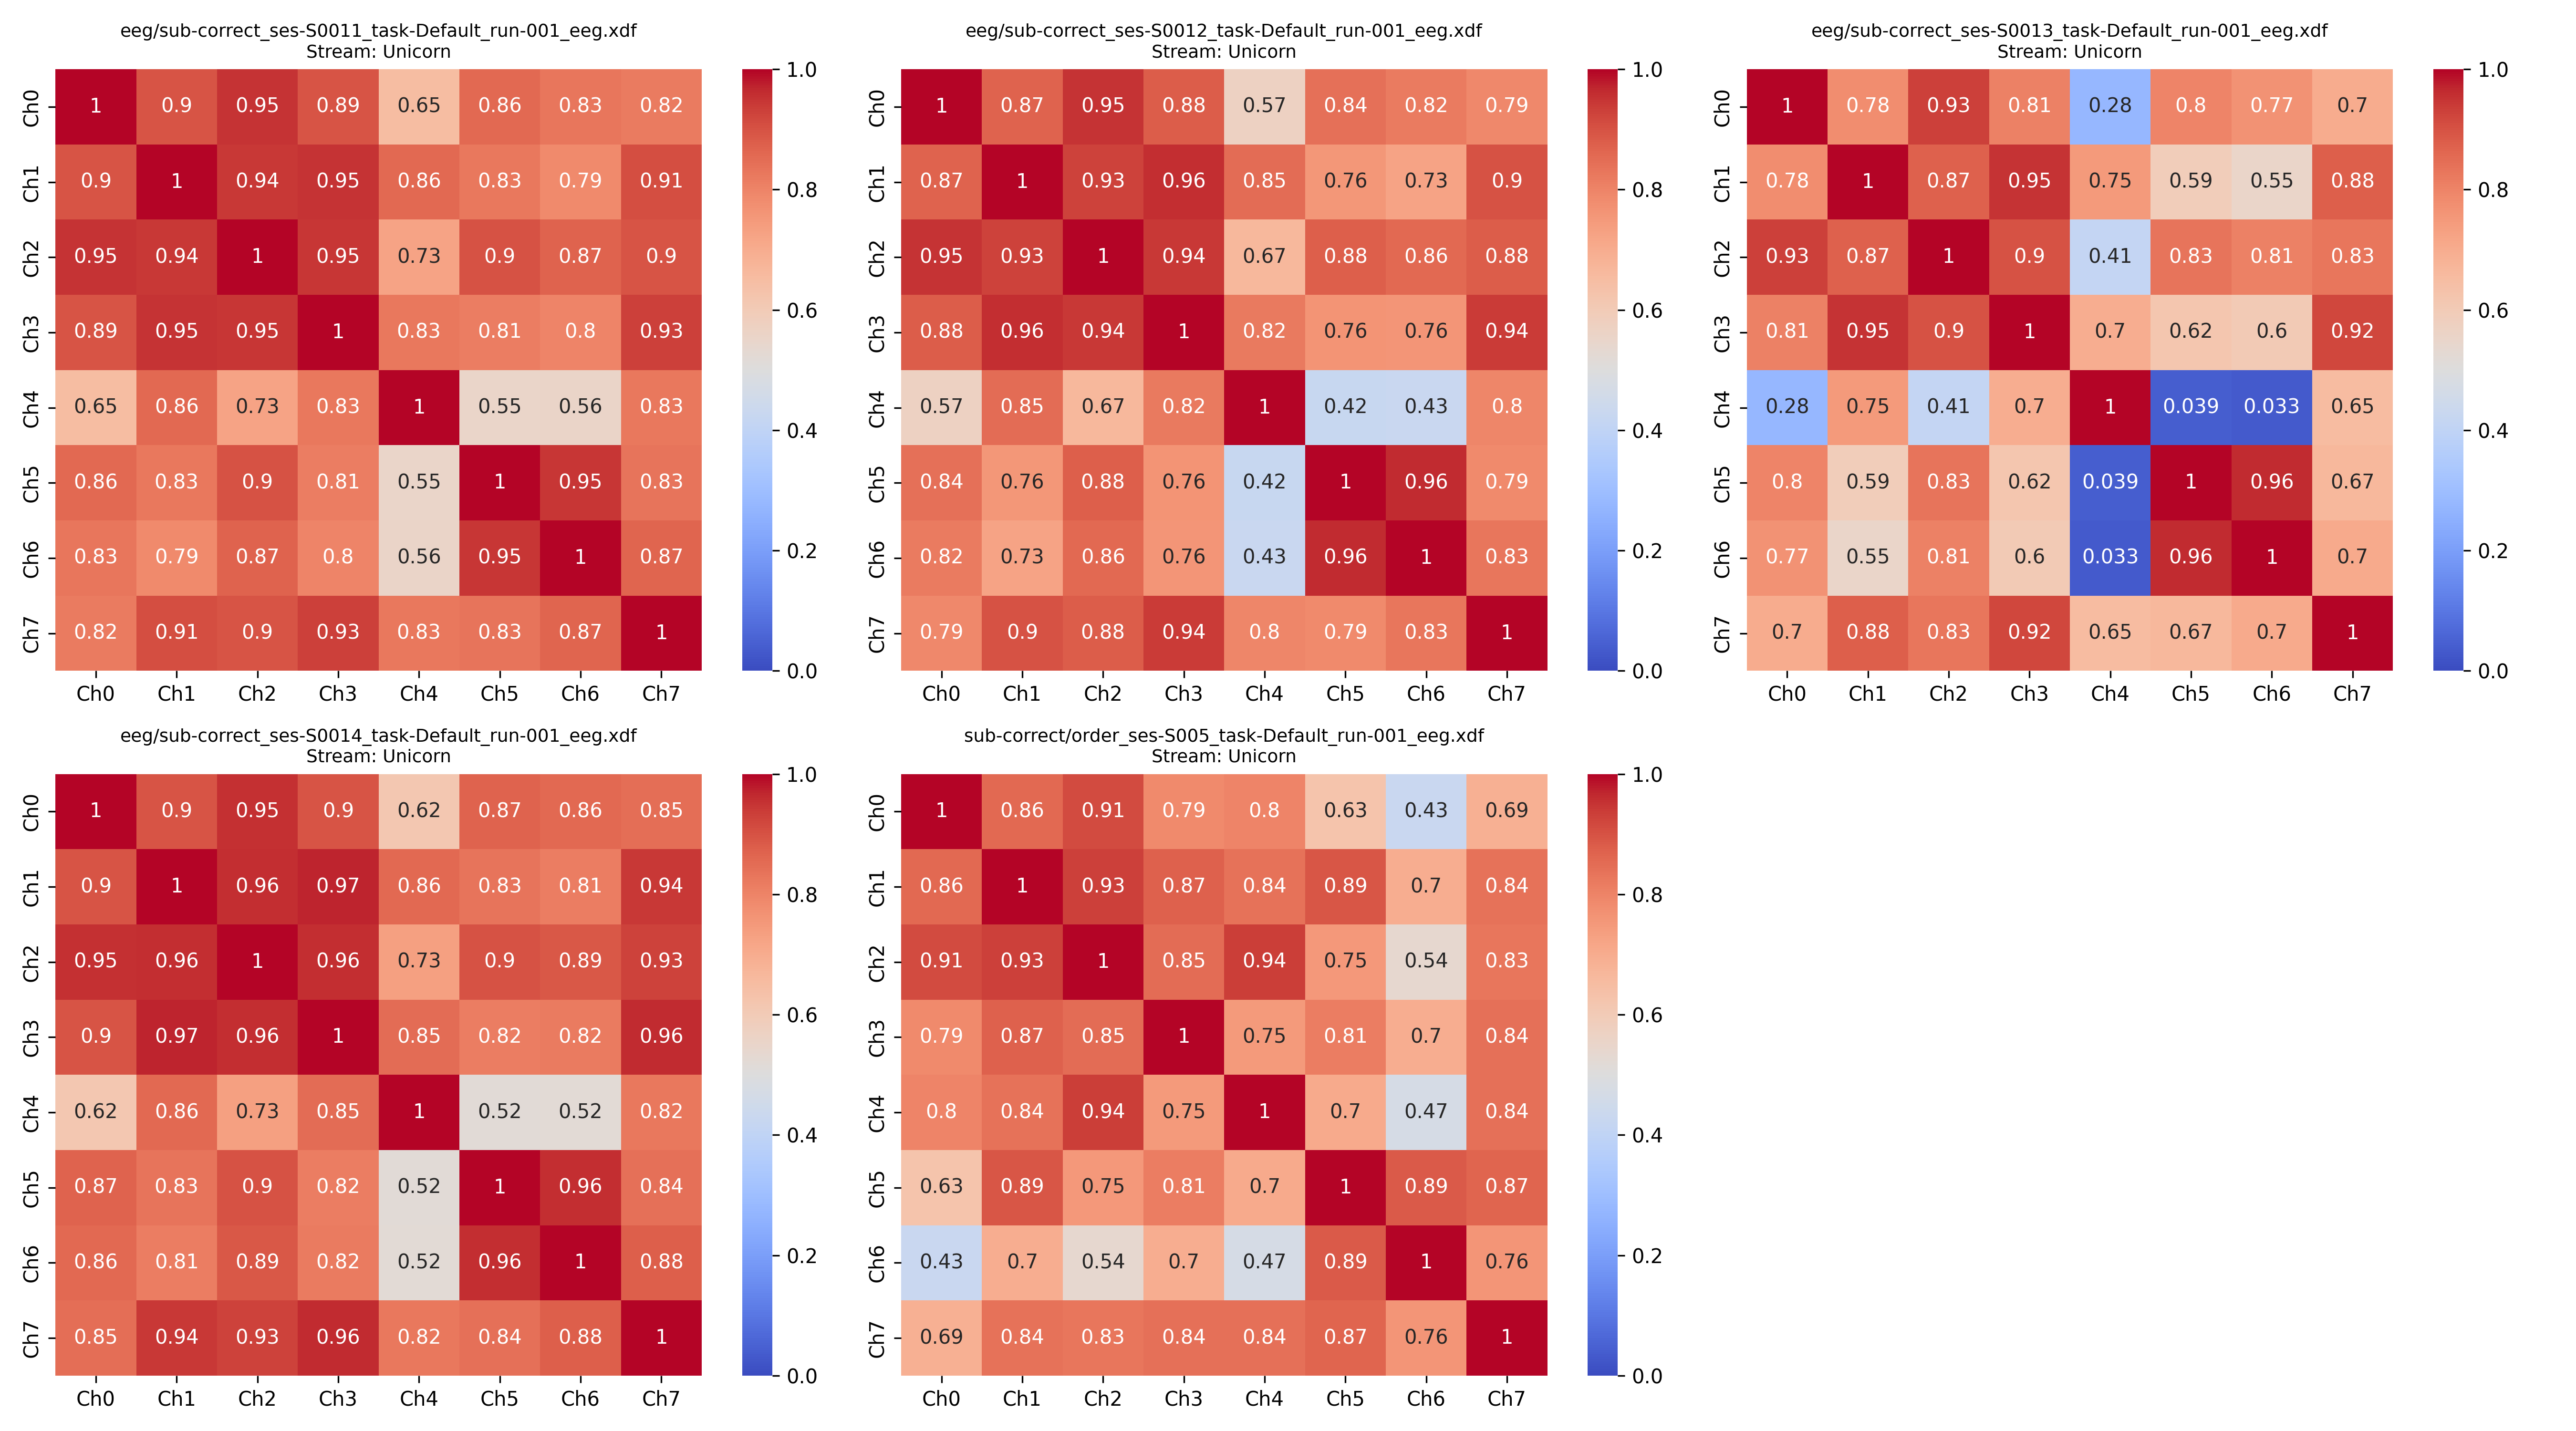

In the controlled dataset, sessions recorded with the correct channel order (sub‑correct; 5 sessions) showed consistently high positive correlations between channels, with most off‑diagonal coefficients in the range 0.7–0.95 and uniformly warm (red–orange) heatmaps.


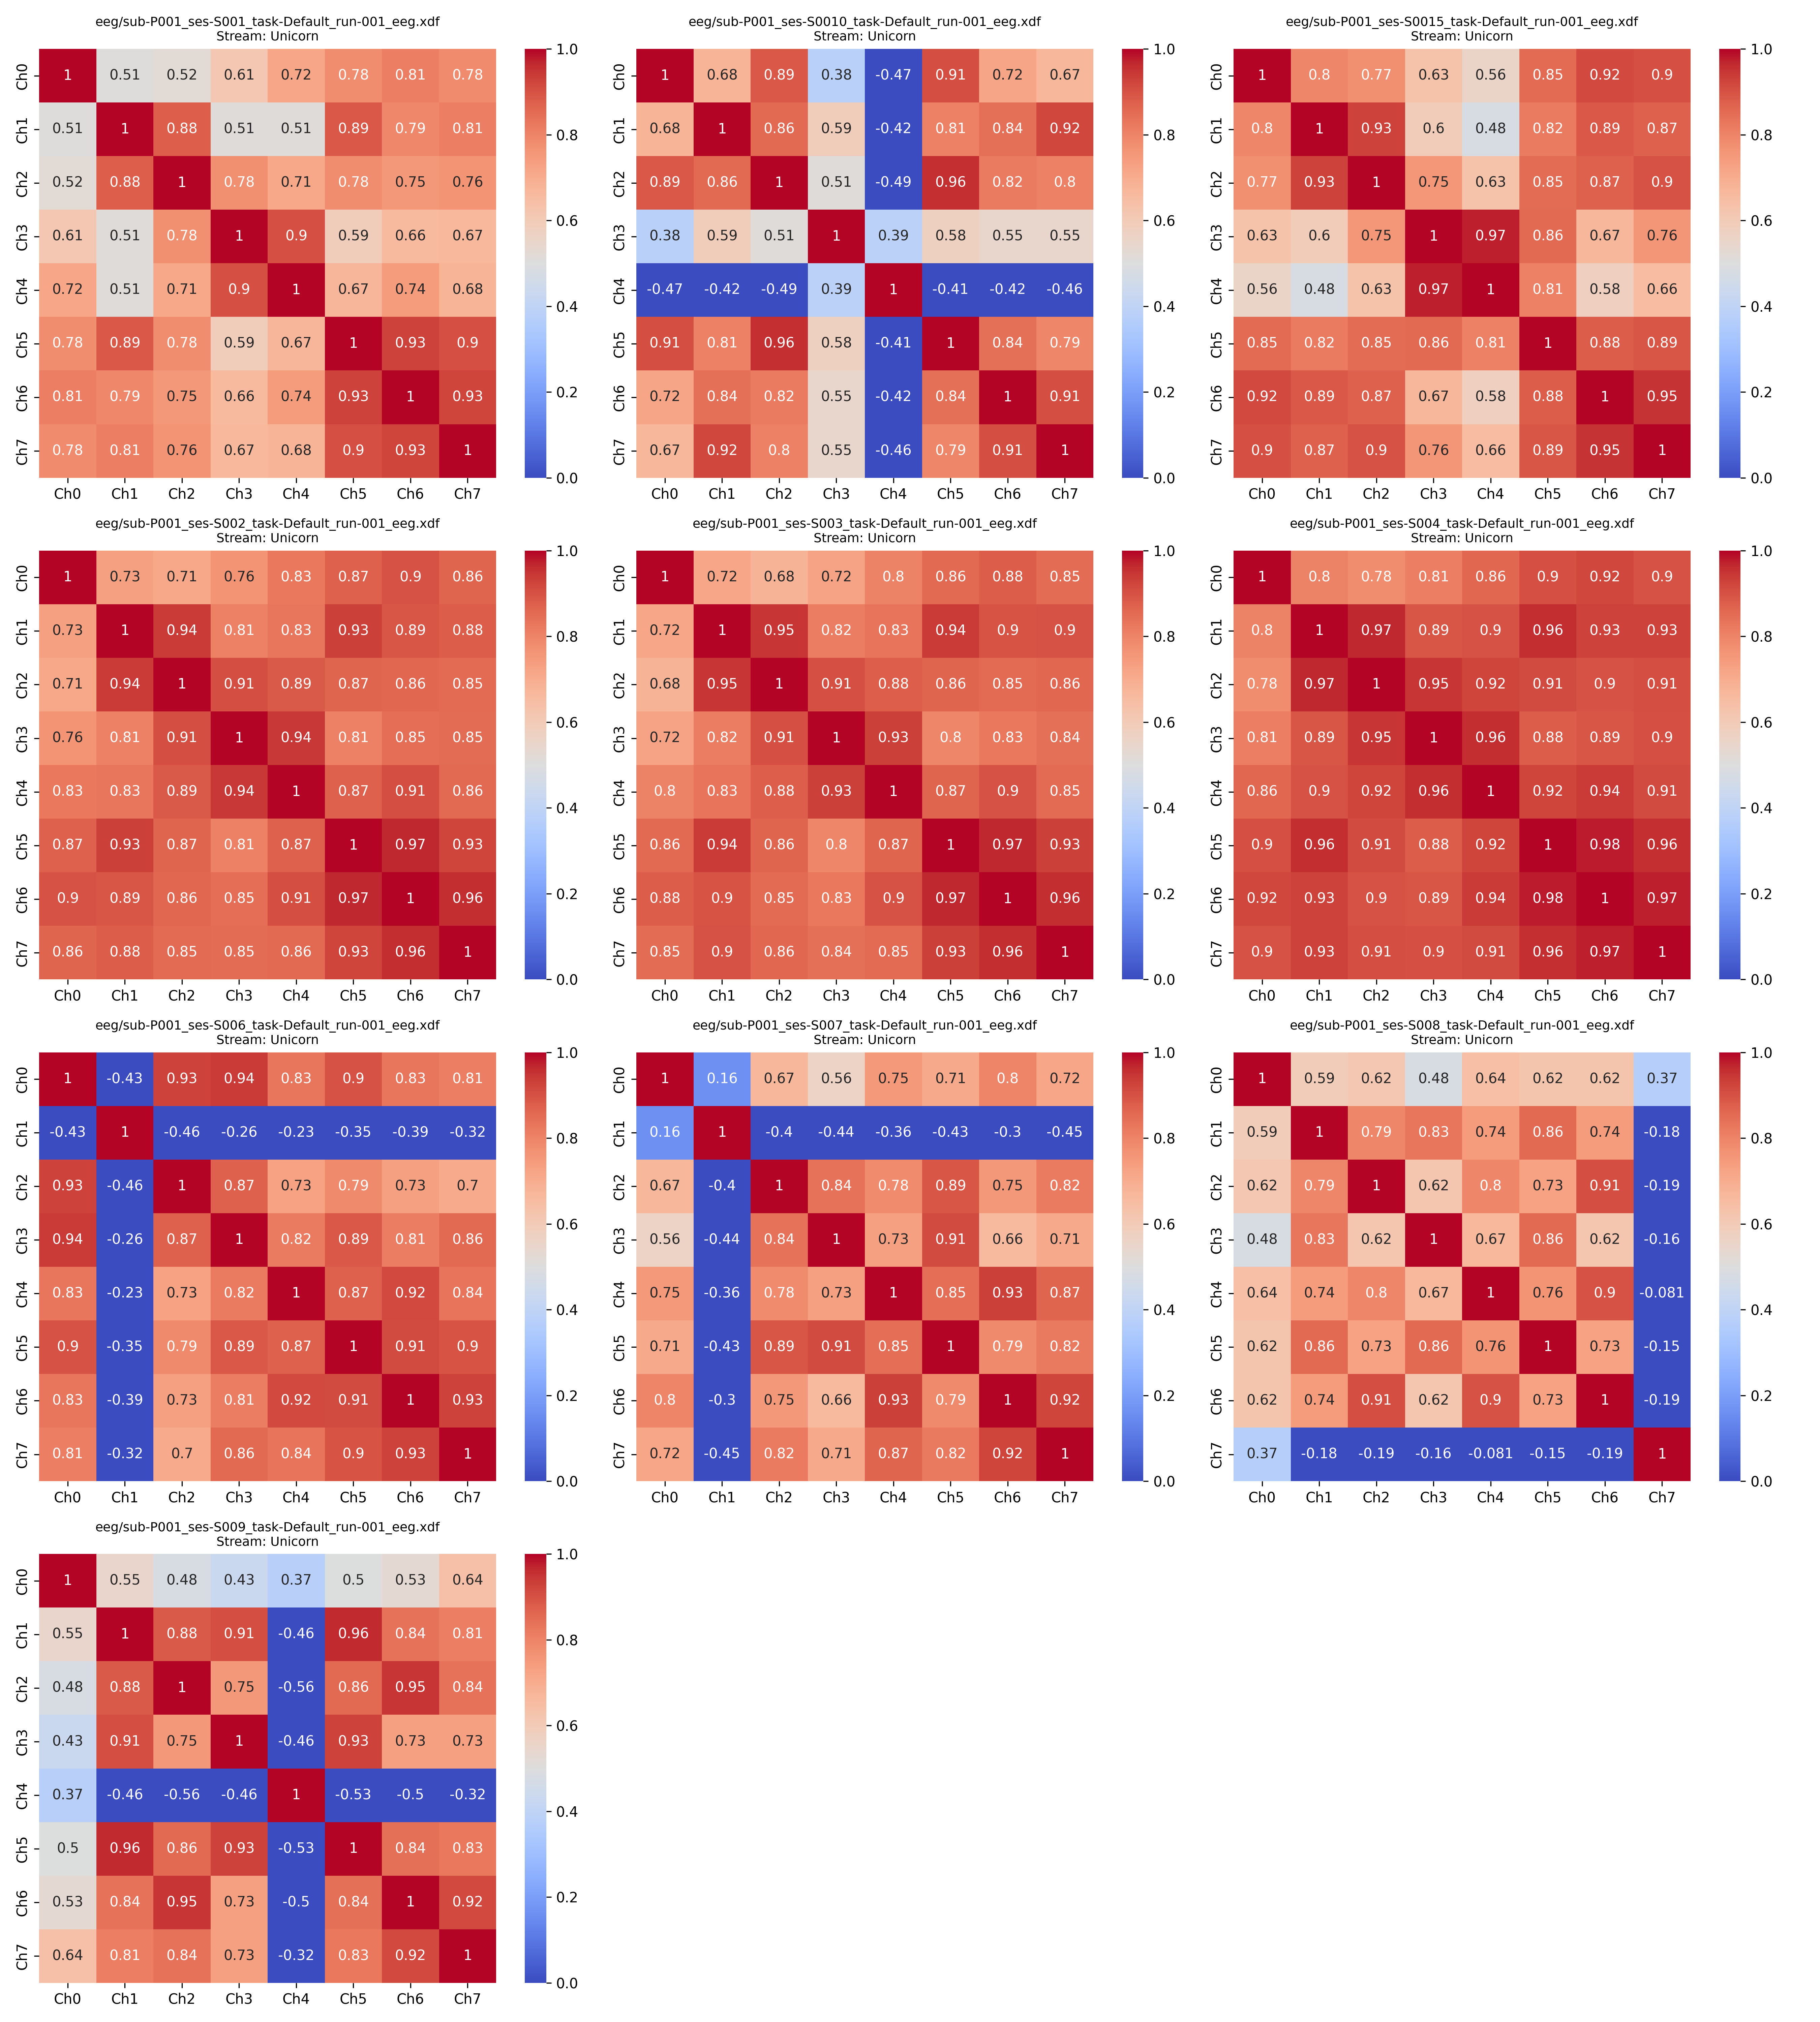

In contrast, the sessions recorded with deliberately permuted channel order (sub‑incorrect; 10 sessions) produced correlation matrices with similar overall correlation strength. Clear difference among the correlation matrices can also be seen due to intersession variations. All these matrices often contained block‑like structures or asymmetric patterns, and in a subset of sessions isolated channel pairs showed reduced or even negative correlations relative to the rest of the matrix.

##### Similarity of correlation matrices within experiments

Across experiments, the within‑experiment similarity analysis revealed differences in how stable the inter‑channel correlation patterns were from session to session. 
For the N‑back experiment, similarity between sessions was generally low to moderate, with most off‑diagonal values between -0.3 and 0.5 and only a few pairs exceeding 0.7. The Jeusa experiment showed a similar picture at smaller scale: four sessions with modest correlations (0.24 - 0.65) and no uniformly high block. In the eeg_data experiment, pairwise similarity was mostly close to zero or slightly negative, except for a single pair of sessions with a correlation of 0.75.
In EEG‑Audio‑Context and EEG_Video_Context, cross‑subject similarity of correlation matrices was mostly low or weakly negative, with a few isolated subject pairs reaching moderate positive correlations (0.5 - 0.8). In the larger multi‑session experiments (Casual EEG Recordings, BPR_GRP_01, gme_2425_data‑code, WPI‑LL), the within‑experiment matrices exhibited a mixture of moderate and low values, typically in the range - 0.3 to 0.8, and no experiment displayed a single homogeneous block where all sessions were strongly correlated with each other.
In the controlled sub‑correct experiment, the five sessions showed extremely high pairwise similarity, with correlations between their 8×8 channel-channel correlation matrices close to 1.0 for all pairwise comparisons among the four “standard” correct sessions, and still moderate correlations (≈0.34 - 0.43) between these sessions and the additional order‑labelling run. In contrast, the sub‑incorrect experiment (10 sessions with deliberately permuted channel order) displayed a clear split: a subset of sessions formed a tightly correlated block (pairwise similarity 0.86-0.99), whereas correlations between this block and the remaining sessions were low or even negative, sometimes dropping below −0.2. All correlation matrices are saved and made available in the accompanying repository.

##### Correlation‑based permutation of the unknown‑order dataset
Correlation‑based reordering was applied to all 8‑channel sessions from the heterogeneous unknown‑order dataset using a reference matrix derived from a correctly ordered session. For each recording, the similarity between its correlation matrix and the reference was quantified before (corr_before) and after (corr_after) permutation, and the optimal channel permutation was stored.
In the BPR_GRP_0(1) experiment, corr_before values ranged from weakly negative to moderate positive (approximately −0.28 to 0.38), whereas corr_after increased to values between about 0.59 and 0.94 after applying the best permutation. Similar patterns were observed for both “busy” and “calm” conditions, with many sessions achieving post‑reordering correlations above 0.8. The corresponding optimal permutations were non‑trivial and varied across subjects, though certain index patterns recurred (for example permutations starting with (7, 3, 4, 2, 0, 6, 5, 1) or (5, 1, 4, 2, 0, 6, 7, 3) in multiple BPR_GRP_0(1) subjects).​

For other experiments (e.g. Casual EEG, gme_2425_data‑code, WPI‑LL, EEG‑Audio‑Context, EEG_Video_Context, N‑back and related tasks), the same general trend held: pre‑reordering correlations were typically low (close to 0 or mildly negative), while post‑reordering correlations increased substantially, often into the range 0.6–0.85, depending on the experiment.

##### Correlation‑based permutation of the known‑order dataset

For the controlled “sub‑incorrect” dataset, before reordering, the similarity between each scrambled session and the reference (corr_before) ranged from moderately negative (−0.23) to moderately positive (0.69), indicating substantial distortion of the correlation structure by the applied permutations. After searching over channel permutations that maximised matrix‑to‑matrix similarity, all sessions showed a marked increase in similarity (corr_after between 0.72 and 0.89).

##### Reordering sub‑incorrect sessions to the true channel order
For the controlled dataset, each of the ten sub‑incorrect sessions was reordered using the known ground‑truth permutation, and its correlation matrix was compared with the reference sub‑correct matrix. Visual inspection of the three‑panel plots (original, reference, reordered) shows that the original sub‑incorrect matrices differ markedly from the reference, with rarely any clustered channels. After applying the true permutation, the reordered matrices become much more similar to the reference: clear clusters formation, and the overall colour pattern (distribution of red and orange tiles) closely matches that of the reference in most sessions. Quantitatively, the reported “Reordered Correlation” values increased in comparision with the correlation value of original disordered matrix except session 09 and 10 whose correlation values reportedly decreased after correctly ordering the channels.

#### Impact of bad channels

To investigate the above result, Bad‑channel analysis was performed for all ten sub‑incorrect sessions after reordering to the ground‑truth channel order.
Across the ten sessions, between 0 and 3 channels were flagged as bad. Session S003 contained no bad channels, whereas sessions S0010, S008 and S009 each had three bad channels, typically involving combinations of Ch0, Ch3, Ch4 and Ch7. When correlations were recomputed after masking these channels, the similarity values corr_ignoring_bad ranged from 0.37 to 0.84. Sessions with a single bad channel (S001, S0015, S002, S004, S007) showed intermediate masked correlations between about 0.52 and 0.69, while sessions with three bad channels (S0010, S008, S009) showed the highest masked correlations (0.78–0.84). The only session with two bad channels (S006) had the lowest masked correlation (0.37).

#### Discussion and Conclusion

The present work aimed to address the problem of inconsistent EEG channel ordering across datasets and sessions, which poses a significant challenge for large-scale or cross-experimental modeling. It is hypothesized that the inter-channel correlation structure could serve as a basis for the underlying spatial and functional relationships between electrodes, and therefore be used to recover the correct channel ordering through permutation-based matching.

The result from the analysis of inter - channel correlation matrices in the sub-correct of known order dataset suggests that inter-channel correlation structure encodes spatial topology. The consistently high pairwise similarity between sessions (near 1.0) and clear clustering patterns is supported by the principle of volume conduction where proximal electrodes record highly correlated signals due to the spread of electrical potentials through the skull and tissue (Satyanarayana, 2014; Truong et al., 2022). The sharp contrast observed in the sub-incorrect sessions where correlation structures were scattered confirms that channel permutation disrupts this spatial locality without altering the signal content itself. By showing that ground-truth reordering restores the original clustering patterns, this study confirms that correlation matrices provide a reliable, data-driven fingerprint for channel order.
Although the controlled environment showed clear results, the analysis of unknown order datasets proved the influence of real world variables. While some tasks, such as the N-back task, showed moderate to high correlations with visible clustering, others (e.g., GME_24_25 and WPI-LL) exhibited uniformly high correlations across most channel pairs. In contrast, several datasets displayed heterogeneous or asymmetric correlation patterns, including isolated channels with weak or negative correlations.
Such variability is consistent with prior observations of strong intra- and inter-subject variability in EEG recordings, driven by differences in cognitive state, task conditons, electrode contact quality, and physiological noise sources (Saha & Baumert, 2020; Roy et al., 2019). Importantly, these findings indicate that raw correlation patterns alone are not universally stable across experiments. 

A key finding is that correlation-based permutation significantly improved alignment between unknown-order or scrambled sessions and a correctly ordered reference. Across both unknown and controlled datasets, the similarity between session-wise correlation matrices and the reference increased substantially after reordering, often reaching values above 0.8. Interestingly, in the controlled dataset where the true channel order was known, applying the actual ground-truth reordering did not always result in higher correlation coefficients. In several cases, the correlation obtained after enforcing the true physical order was lower than that achieved through blind, correlation-optimized reordering. This observation indicates that correlation similarity reflects alignment of functional connectivity patterns rather than strict recovery of anatomical or physical electrode order. Session-specific noise, bad channels, and distortions in correlation structure can cause the true ordering to deviate from the reference pattern under a purely correlation-based metric.

A key finding from the sub-incorrect analysis is that reordering to the true ground truth improved similarity for most sessions but actually decreased it for sessions 09 and 10. The subsequent bad-channel analysis showed these specific sessions contained multiple bad channels (e.g., Ch0, Ch3, Ch4) that distorted the correlation value. Masking these channels led to substantial increase (upto 0.83) in correlation similarity which proves that the presence of bad channels severly affects the correlation coefficient. Hence, robust channel reordering pipelines must be integrated with automated artifact detection (Islam et al., 2016; Roy et al., 2019).

Together, these findings suggest that correlation-based channel reordering is not sufficient as a fully unsupervised solution but can serve as a useful supporting tool in semi-supervised harmonization pipelines. Future work may benefit from incorporating additional constraints such as electrode geometry, frequency-specific connectivity patterns, or supervised learning approaches to improve robustness.

#### Acknowledgement

I would like to sincerely thank my professor Dr. Felix Putze for his guidance, patience, and consistent support throughout the course of this project. His thoughtful feedback and encouragement were instrumental in maintaining clarity and and in the successful completion of this work.

#### References

1. Balsam, H., et al. (2020). CHARM: A Channel Reordering Module for Training a Single Neural Network Across Heterogeneous EEG Data. arXiv preprint arXiv:2010.13694. Available: https://david.grangier.info/papers/2021/saeeds-eeg-reordering-2021.pdf
2. Cui S, Lee D, Wen D. Toward brain-inspired foundation model for EEG signal processing: our opinion. Front Neurosci. 2024 Dec 4;18:1507654. doi: 10.3389/fnins.2024.1507654. PMID: 39697779; PMCID: PMC11652537.
3. Islam M. K., Rastegarnia A., Yang Z. (2016). Methods for artifact detection and removal from scalp EEG: a review. Clin. Neurophysiol. 46, 287–305. 10.1016/j.neucli.2016.07.002. Available: https://pubmed.ncbi.nlm.nih.gov/27751622/
4. Mattiev J, Sajovic J, Drevenšek G, Rogelj P. Assessment of Model Accuracy in Eyes Open and Closed EEG Data: Effect of Data Pre-Processing and Validation Methods. Bioengineering (Basel). 2022 Dec 29;10(1):42. doi: 10.3390/bioengineering10010042. PMID: 36671614; PMCID: PMC9854523. Available: https://pmc.ncbi.nlm.nih.gov/articles/PMC9854523/
5. Meyer M. C., van Oort E. S., Barth M. (2013). Electrophysiological correlation patterns of resting state networks in single subjects: a combined eeg–fmri study. Brain Topography 26, 98–109. 10.1007/s10548-012-0235-0. Available: https://pmc.ncbi.nlm.nih.gov/articles/PMC3536973/
6. M. Orban, M. Elsamanty, K. Guo, S. Zhang, and H. Yang, “A review of brain activity and eeg-based brain–computer interfaces for rehabilitation application,” Bioengineering, vol. 9, no. 12, p. 768, Dec. 2022. [Online]. Available: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9774292/
7. Roy Y., Banville H., Albuquerque I., Gramfort A., Falk T. H., Faubert J. (2019). Deep learning-based electroencephalography analysis: a systematic review. J. Neural Eng. 16:051001. 10.1088/1741-2552/ab260c. Available: https://pubmed.ncbi.nlm.nih.gov/31151119/
8. Saha S, Baumert M. Intra- and Inter-subject Variability in EEG-Based Sensorimotor Brain Computer Interface: A Review. Front Comput Neurosci. 2020 Jan 21;13:87. doi: 10.3389/fncom.2019.00087. PMID: 32038208; PMCID: PMC6985367. Available: https://pmc.ncbi.nlm.nih.gov/articles/PMC6985367/#B51
9. Satyanarayana, J. V. (2014). Compressed EEG acquisition with limited channels using compressive sensing and convex optimization. arXiv preprint arXiv:1407.1285. Available: https://arxiv.org/pdf/1407.1285
10. Truong, N.C.D., Wang, X., Wanniarachchi, H. et al. Mapping and understanding of correlated electroencephalogram (EEG) responses to the newsvendor problem. Sci Rep  12, 13800 (2022). https://doi.org/10.1038/s41598-022-17970-x
11. Wang, J., Zhao, S., Luo, Z., Zhou, Y., Jiang, H., Li, S., Li, T., & Pan, G. (2025). CBraMod: A criss-cross brain foundation model for EEG decoding. In Proceedings of the International Conference on Learning Representations (ICLR 2025). Available: https://proceedings.iclr.cc/paper_files/paper/2025/file/bbbd6d915cb90be21c1254a82d45cedd-Paper-Conference.pdf
12. Yi, K., Wang, Y., Ren, K., & Li, D. (2023). Learning topology-agnostic EEG representations with geometry-aware modeling. In Proceedings of the 37th Conference on Neural Information Processing Systems (NeurIPS 2023). Available: https://seqml.github.io/MMM/NeurIPS_2023_MMM.pdf